# Step 1: Extract Data
### Import libraries, set paths & constants

In [1]:
%matplotlib inline

In [2]:
import csv
import numpy as np
import os
import pandas as pd
import sys
import time
import matplotlib.pyplot as plt

from IPython.display import display
from collections import defaultdict
from pandas import DataFrame

In [3]:
# Set these as appropriate
MIMIC_PATH = '/Users/Mark/Downloads/MIMIC Data/Original'
VARIABLE_MAP_FILE = '/Users/Mark/Documents/GitHub/MIMIC-Machine-Learning/Reference Files/mimic3_map.csv'
OUTPUT_PATH = '/Users/Mark/Downloads/MIMIC Data/Processed'

NB_ROWS_CHARTEVENTS = 263201376
NB_ROWS_LABEVENTS = 27872576
NB_ROWS_OUTPUTEVENTS = 4349340

try:
    os.makedirs(OUTPUT_PATH)
except:
    pass

### Filter data by various criteria

In [4]:
pats = pd.read_csv(os.path.join(MIMIC_PATH, 'PATIENTS_DATA_TABLE.csv'))
pats = pats[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD']]
pats.DOB = pd.to_datetime(pats.DOB)
pats.DOD = pd.to_datetime(pats.DOD)

admits = pd.read_csv(os.path.join(MIMIC_PATH, 'ADMISSIONS_DATA_TABLE.csv'))
admits = admits[['SUBJECT_ID', 'HADM_ID', 'DEATHTIME', 'ETHNICITY', 'DIAGNOSIS']]
admits.DEATHTIME = pd.to_datetime(admits.DEATHTIME)

stays  = pd.read_csv(os.path.join(MIMIC_PATH, 'ICUSTAYS_DATA_TABLE.csv'))
print('START:', stays.ICUSTAY_ID.unique().shape[0], stays.HADM_ID.unique().shape[0], stays.SUBJECT_ID.unique().shape[0])
stays = stays.ix[(stays.FIRST_WARDID == stays.LAST_WARDID) & (stays.FIRST_CAREUNIT == stays.LAST_CAREUNIT)]
stays = stays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE', 'INTIME', 'OUTTIME', 'LOS']]

stays.INTIME = pd.to_datetime(stays.INTIME)
stays.OUTTIME = pd.to_datetime(stays.OUTTIME)
print('REMOVE ICU TRANSFERS:', stays.ICUSTAY_ID.unique().shape[0], stays.HADM_ID.unique().shape[0], stays.SUBJECT_ID.unique().shape[0])

stays = stays.merge(admits, how='inner', left_on=['SUBJECT_ID', 'HADM_ID'], right_on=['SUBJECT_ID', 'HADM_ID'])
stays = stays.merge(pats, how='inner', left_on=['SUBJECT_ID'], right_on=['SUBJECT_ID'])

START: 61532 57786 46476
REMOVE ICU TRANSFERS: 55830 52834 43277


In [5]:
stays['AGE'] = (stays.INTIME - stays.DOB).apply(lambda s: s / np.timedelta64(1, 's')) / 60./60/24/365
stays.loc[stays.AGE<0, 'AGE'] = 90
stays = stays.ix[stays.AGE >= 18]
print('REMOVE PATIENTS AGE < 18:', stays.ICUSTAY_ID.unique().shape[0], stays.HADM_ID.unique().shape[0], stays.SUBJECT_ID.unique().shape[0])

REMOVE PATIENTS AGE < 18: 47702 44815 35380


In [19]:
stays = stays.ix[stays.LOS >= .25]
print('REMOVE PATIENTS LOS < 6hrs:', stays.ICUSTAY_ID.unique().shape[0], stays.HADM_ID.unique().shape[0], stays.SUBJECT_ID.unique().shape[0])

REMOVE PATIENTS LOS < 6hrs: 47278 44540 35165


### Structure data by patients

#### Build mapping dataframe
This imports the map file with the following criteria:  
1) Drop labels not mapped to a variable  
2) Unsure variables (denoted by the 'ZZZZ' prefix)  
2) Variables with 0 counts in respective events tables

In [20]:
mp = DataFrame.from_csv(VARIABLE_MAP_FILE, index_col=None).fillna('').astype(str)
mp.COUNT = pd.to_numeric(mp.COUNT)
mp = mp.ix[(mp.VARIABLE != '') & (mp.COUNT>0)]
mp = mp.ix[mp.VARIABLE.apply(lambda s: not s.startswith('ZZZZ'))]
mp = mp.set_index('ITEMID')

#### Random sampling of stays (uncomment for testing)

In [8]:
stay_idx = np.random.randint(0, high=stays.shape[0], size=100)
stays = stays.iloc[stay_idx]

#### Create folders for each episode, each with stays.csv and observations.csv

In [21]:
OBS_HEADER = [ 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'VARIABLE', 'VALUE', 'VALUEUOM', 'MIMIC_LABEL' ]
nb_subjects = stays.SUBJECT_ID.unique().shape[0]
t0 = time.time()
for i, subject_id in enumerate(stays.SUBJECT_ID.unique()):
    sys.stdout.write('\rSUBJECT {0} of {1}...'.format(i, nb_subjects))
    dn = os.path.join(OUTPUT_PATH, 'Episodes', str(subject_id))
    try:
        os.makedirs(dn)
    except:
        pass
    
    stays.ix[stays.SUBJECT_ID == subject_id].sort_values(by='INTIME').to_csv(os.path.join(dn, 'stays.csv'), index=False)
    f = open(os.path.join(dn, 'observations.csv'), 'w')
    f.write(','.join(OBS_HEADER) + '\n')
    f.close()
        
tf = time.time()
print ('DONE in %.1f seconds' % (tf-t0))

SUBJECT 35164 of 35165...DONE in 634.9 seconds


#### Build observations files

In [22]:
subject_ids = set([ str(s) for s in stays.SUBJECT_ID.unique() ])

tables = [ 'chartevents', 'labevents', 'outputevents' ]
nb_rows = [ NB_ROWS_CHARTEVENTS, NB_ROWS_LABEVENTS, NB_ROWS_OUTPUTEVENTS ]
t0 = time.time()

for table, nbr in zip(tables, nb_rows):
    r = csv.DictReader(open(os.path.join(MIMIC_PATH, table.upper() + '_DATA_TABLE.csv'), 'r'))
    curr_subject_id = ''
    last_write_no = 0
    last_write_nb_rows = 0
    last_write_subject_id = ''
    curr_obs = []
    for i, row_in in enumerate(r):
#         if i >= 20000:
#             break
        if last_write_no != '':
            sys.stdout.write('\rprocessing {0}: ROW {1} of {2}...last write '
                             '({3}) {4} rows for subject {5}'.format(table, i+1, nbr, last_write_no,
                                                                     last_write_nb_rows, last_write_subject_id))
        else:
            sys.stdout.write('\rprocessing {0}: ROW {1} of {2}...'.format(table, i+1, nbr))
        
        subject_id = row_in['SUBJECT_ID']
        itemid = row_in['ITEMID']
        
        if subject_id not in subject_ids or itemid not in mp.index:
            continue
            
        row_out = { 'SUBJECT_ID': subject_id,
                    'HADM_ID': row_in['HADM_ID'],
                    'CHARTTIME': row_in['CHARTTIME'],
                    'VARIABLE': mp.VARIABLE[row_in['ITEMID']],
                    'MIMIC_LABEL': mp.LABEL[row_in['ITEMID']],
                    'VALUE': row_in['VALUE'],
                    'VALUEUOM': row_in['VALUEUOM'] }
        
        try:
            row_out['ICUSTAY_ID'] = row_in['ICUSTAY_ID']
        except:
            row_out['ICUSTAY_ID'] = ''

        if curr_subject_id != '' and curr_subject_id != subject_id:
            last_write_no += 1
            last_write_nb_rows = len(curr_obs)
            last_write_subject_id = curr_subject_id
            fn = os.path.join(OUTPUT_PATH, 'Episodes', str(curr_subject_id), 'observations.csv')
            w = csv.DictWriter(open(fn, 'a', newline=''), fieldnames=OBS_HEADER, quoting=csv.QUOTE_MINIMAL)
            w.writerows(curr_obs)
            curr_obs = []

        curr_obs.append(row_out)
        curr_subject_id = subject_id

    if curr_subject_id != '':
        last_write_no += 1
        last_write_nb_rows = len(curr_obs)
        last_write_subject_id = curr_subject_id
        fn = os.path.join(OUTPUT_PATH, 'Episodes', str(curr_subject_id), 'observations.csv')
        w = csv.DictWriter(open(fn, 'a', newline=''), fieldnames=OBS_HEADER, quoting=csv.QUOTE_MINIMAL)
        w.writerows(curr_obs)
        curr_obs = []
    
    del r
#     sys.stdout.write('\rprocessing {0}: ROW {1} of {2}...last write '
#                      '({3}) {4} rows for subject {5}'.format(table, i, nbr, last_write_no,
#                                                              last_write_nb_rows, last_write_subject_id))
    tf = time.time()
    print('\nDONE after {:.0f} seconds'.format(tf-t0))

processing chartevents: ROW 263201375 of 263201376...last write (2085423) 18 rows for subject 32622DONE after 29944 seconds
processing labevents: ROW 27872575 of 27872576...last write (353662) 2 rows for subject 93325DONE after 34524 seconds
processing outputevents: ROW 4349339 of 4349340...last write (0) 0 rows for subject DONE after 34647 seconds


### Structure data by ITEMIDs

In [20]:
mp = DataFrame.from_csv(VARIABLE_MAP_FILE, index_col='ITEMID').fillna('').astype(str)
OBS_HEADER = [ 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'VALUE', 'VALUEUOM', 'MIMIC_LABEL' ]

tables = [ 'CHARTEVENTS', 'LABEVENTS', 'OUTPUTEVENTS' ]
# item_dicts = ['chartitems', 'labitems', 'outputitems']
nb_rows = [ NB_ROWS_CHARTEVENTS, NB_ROWS_LABEVENTS, NB_ROWS_OUTPUTEVENTS ]
t0 = time.time()

for table, nbr in zip(tables, nb_rows):
    try:
        os.makedirs(os.path.join(OUTPUT_PATH, table))
    except:
        print('%s Directory already exists. Delete directory first and run again' % table)
        continue
    r = csv.DictReader(open(os.path.join(MIMIC_PATH, table + '_DATA_TABLE.csv'), 'r'))
    w_dict = {}
    for i, row_in in enumerate(r):
        item_id = row_in['ITEMID']
        sys.stdout.write('\rprocessing {0}: ROW {1} of {2}...'.format(table, i+1, nbr))
        
        row_out = { 'SUBJECT_ID': row_in['SUBJECT_ID'],
                    'HADM_ID': row_in['HADM_ID'],
                    'CHARTTIME': row_in['CHARTTIME'],
                    'MIMIC_LABEL': mp.LABEL[int(item_id)],
                    'VALUE': row_in['VALUE'],
                    'VALUEUOM': row_in['VALUEUOM'] }
        try:
            row_out['ICUSTAY_ID'] = row_in['ICUSTAY_ID']
        except:
            row_out['ICUSTAY_ID'] = ''
            
        if item_id not in w_dict:
            fn = os.path.join(OUTPUT_PATH, 'ITEMS', table, str(item_id) + '.csv')
            w_dict[item_id] = csv.DictWriter(open(fn, 'a+', newline=''), fieldnames=OBS_HEADER, quoting=csv.QUOTE_MINIMAL)
            w_dict[item_id].writeheader()

        w_dict[item_id].writerow(row_out)
        

    del r, w_dict
    tf = time.time()
    print('\nDONE after {:.1f} seconds'.format(tf-t0))


chartitems Directory already exists. Delete directory first and run again
labitems Directory already exists. Delete directory first and run again
processing outputevents: ROW 4349338 of 4349340...last write 
DONE after 313.0 seconds


### Exploratory analysis: stats, measurement frequency, visualization

1/7 ITEMID 778 added to list. N=283616, u=41.73, std=9.92, min=0, max=100
2/7 ITEMID 220235 added to list. N=140215, u=42.30, std=12.93, min=0, max=2583
3/7 ITEMID 858 added to list. N=10623, u=48.97, std=13.27, min=0, max=100
4/7 ITEMID 3835 added to list. N=9486, u=48.51, std=12.92, min=11, max=165
5/7 ITEMID 3836 added to list. N=8445, u=53.40, std=12.69, min=10, max=138
6/7 ITEMID 4201 added to list. N=8106, u=53.35, std=12.73, min=10, max=138
7/7 ITEMID 3784 added to list. N=5314, u=51.15, std=13.70, min=1, max=140

7/7 input ITEMIDs have valid datasets... making plots


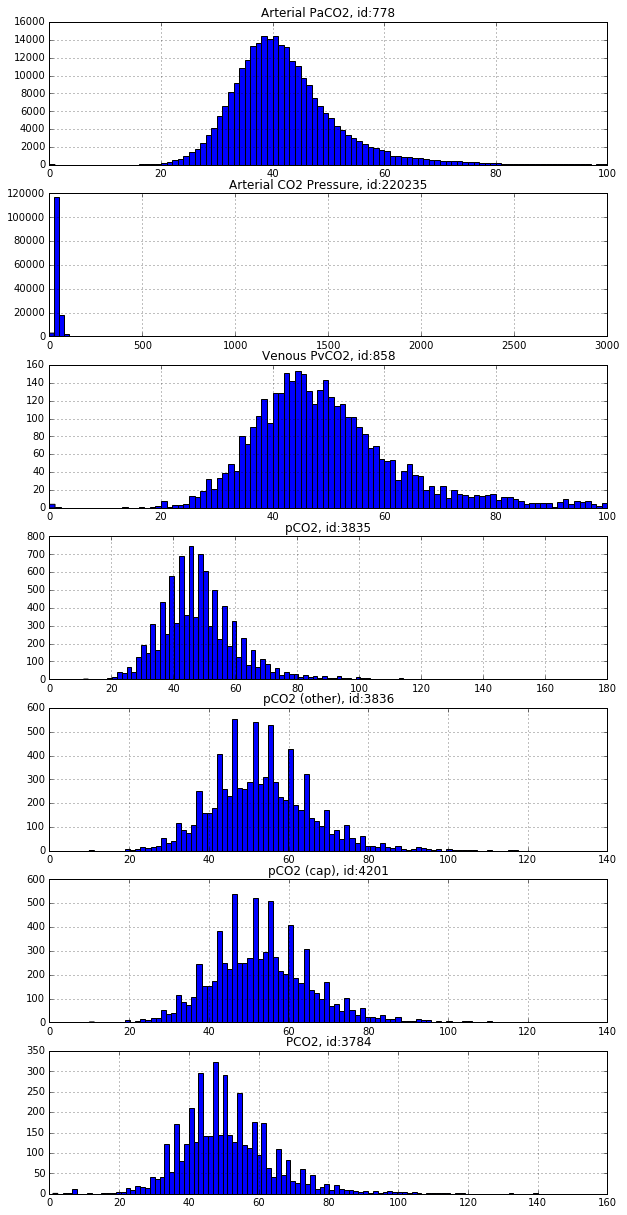

In [188]:
# Build list of itemids of interest here-
ids_cap_refill_rate = [3348,115,8377,224308,223951]
ids_bp_diastolic = [8368,8441,220180,220051,8502,225310,8555,8440,8503,8504,8507,8506,224643,227242,8364,8448,220060,8508,8505,8444,8446,226094,226092,8445,226096,228151]
ids_pco2 = [50804,50818,778,777,220235,225698,3810,858,3835,3808,857,3836,3809,4201,4199,3784,223679]
ids_pco2f = [778,220235,858,3835,3836,4201,3784]
ids_urineout = [40055,226559,43175,40069,40094,40065,40061,40715,226627,40473,227489,40085,40057,40056,40405,40288]
ids_urineoutf = [40055,226559,40715,40473,227489,40057,40056,40405]
ids_bilirubin = [50885,51464,50883,50884,225690,225651,50838,51028,51049,51465,4948,226998,51012]
ids_bilirubinf = [50885,225690]
ids_hr = [211,212,220045]
ids = ids_pco2f

itemids = []
df_list = []
mp = DataFrame.from_csv(VARIABLE_MAP_FILE, index_col='ITEMID')

# Calculate stats
for i, itemid in enumerate(ids):
    fns = glob.glob(OUTPUT_PATH + '/ITEMS/*/' + str(itemid) + '.csv')
    sys.stdout.flush()
    if len(fns) > 1:
        print('ITEMID {0} found in multiple directories.'.format(itemid))
    elif len(fns) == 1:
        df = DataFrame.from_csv(fns[0], index_col=None)['VALUE']
        df = pd.to_numeric(df, errors='coerce')
        df_list.append(df)
        itemids.append(itemid)
        print('{0}/{1} ITEMID {2} added to list. N={3:d}, u={4:.2f}, std={5:.2f}, min={6:.0f}, max={7:.0f}'
              .format(i+1, len(ids), itemid, df.shape[0], df.mean(), df.std(), df.min(), df.max()))
    else:
        print('{0}/{1} ITEMID {2}.csv does not exist...skipping'.format(i+1, len(ids), itemid))

# Visualization
num_plots = len(df_list)
print('\n{0}/{1} input ITEMIDs have valid datasets... making plots'.format(num_plots, len(ids)))
sys.stdout.flush()
limit = 50

if num_plots > 0:
    fig, axs = plt.subplots(num_plots, 1)
    if type(axs) is not np.ndarray:
        print('fixing')
        axs = np.array([axs])
    fig.set_size_inches(10,3*num_plots)
    for i, (df, itemid) in enumerate(zip(df_list, itemids)):
        curr_ax = axs[i]
#         curr_ax.set_xlim(0, limit)
#         df = df.ix[df < 100]
        df.hist(ax=axs[i], bins=100)
        curr_ax.set_title(mp.LABEL[itemid] + ', id:' + str(itemid))


In [178]:
def mean_meas_freq(itemid):
    fns = glob.glob(OUTPUT_PATH + '/ITEMS/*/' + str(itemid) + '.csv')
    df = DataFrame.from_csv(fns[0], index_col=None)
#     df = df.dropna(axis=0, subset=['VALUE'])
    df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])
    df = df.sort_values('CHARTTIME')
    pat_groups = df.groupby('SUBJECT_ID')
#     print(df.ix[pat_groups.groups[68]])
    print(df['CHARTTIME'].ix[pat_groups.groups[68]].diff().mean())
    
#     for pat in pat_groups:
        
#     a =df['CHARTTIME'][3]
#     a = pd.to_datetime(df['CHARTTIME'], format=%)
#     print(type(a[3]))
#     print(df)
    
    

mean_meas_freq(858)

0 days 07:47:56.250000
